# Wind Turbine SCADA Data Analytics and Prediction of Turbine Power 

![image](https://user-images.githubusercontent.com/51282928/142767727-dab61a3e-bb06-4fad-925e-aca9319fe870.png)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wind-turbine-scada-dataset/T1.csv


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor as DTRegressor
from sklearn.ensemble import RandomForestRegressor as RFRegressor
from sklearn.ensemble import AdaBoostRegressor as Ada
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

%config InlineBackend.figure_format = 'retina'

# 1. Read data

In [3]:
df = pd.read_csv('../input/wind-turbine-scada-dataset/T1.csv')
df.columns = ['date', 'active_power', 'wind_speed', 'theor_power', 'wind_dir']

df

,date,active_power,wind_speed,theor_power,wind_dir
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...,...
50525,31 12 2018 23:10,2963.980957,11.404030,3397.190793,80.502724
50526,31 12 2018 23:20,1684.353027,7.332648,1173.055771,84.062599
50527,31 12 2018 23:30,2201.106934,8.435358,1788.284755,84.742500
50528,31 12 2018 23:40,2515.694092,9.421366,2418.382503,84.297913


In [4]:
# Convert to datetime format
df['date'] = pd.to_datetime(df['date'])

# Set date column as index
df.set_index('date', inplace=True)

df

,active_power,wind_speed,theor_power,wind_dir
date,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...
2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724
2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599
2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500


# 2. Time series analysis

## Hourly analysis

<AxesSubplot:xlabel='date', ylabel='Active Power (kWh)'>

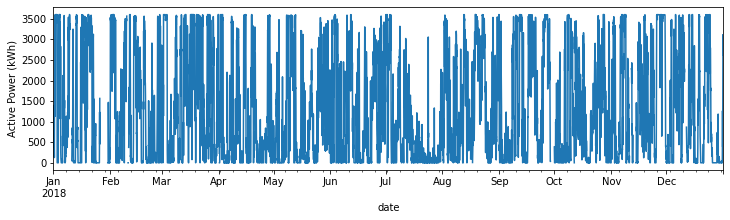

In [5]:
# Resample hourly average power and plot
df.resample('H').mean().active_power.plot(figsize=(12,3), ylabel='Active Power (kWh)')

It is not convenient to see an hourly plot like this. Instead, we can group the dataframe by hours (hour 0 to 24) then take average of active power. 

In [6]:
# Get hours from datetime
dates = df.index
hours = [date.hour for date in dates]
df['hour'] = hours

df

,active_power,wind_speed,theor_power,wind_dir,hour
date,,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,0
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,0
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,0
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,0
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,0
...,...,...,...,...,...
2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724,23
2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599,23
2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500,23


<AxesSubplot:title={'center':'Average of Active Power of each Hours'}, xlabel='hour'>

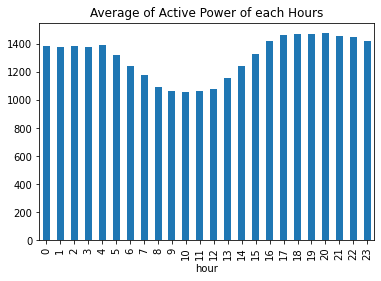

In [7]:
df.groupby('hour').mean().active_power.plot(kind='bar', title='Average of Active Power of each Hours')

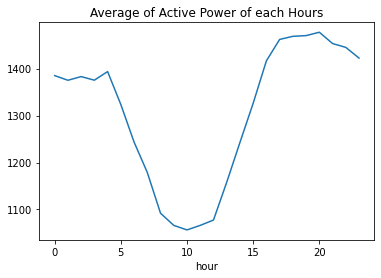

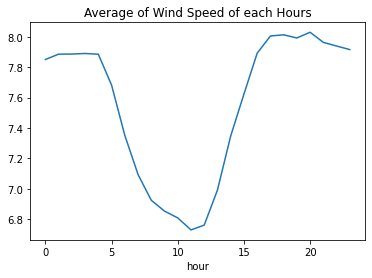

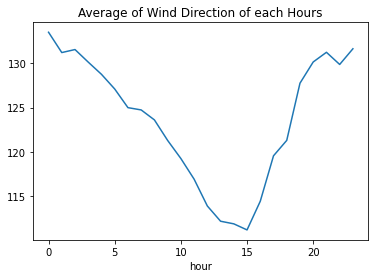

In [8]:
df.groupby('hour').mean().active_power.plot(title='Average of Active Power of each Hours')
plt.show()

df.groupby('hour').mean().wind_speed.plot(title='Average of Wind Speed of each Hours')
plt.show()

df.groupby('hour').mean().wind_dir.plot(title='Average of Wind Direction of each Hours')
plt.show()

## Monthly and weekly analysis

In [9]:
# Get hours from datetime
dates = df.index
months = [date.month for date in dates]
df['month'] = months

df

,active_power,wind_speed,theor_power,wind_dir,hour,month
date,,,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,0,1
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,0,1
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,0,1
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,0,1
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,0,1
...,...,...,...,...,...,...
2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724,23,12
2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599,23,12
2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500,23,12


In [72]:
color = list(np.full(12, 'grey'))
color[2] = 'orange'
color

['grey',
 'grey',
 'orange',
 'grey',
 'grey',
 'grey',
 'grey',
 'grey',
 'grey',
 'grey',
 'grey',
 'grey']

Text(0, 0.5, 'Active Power [kW]')

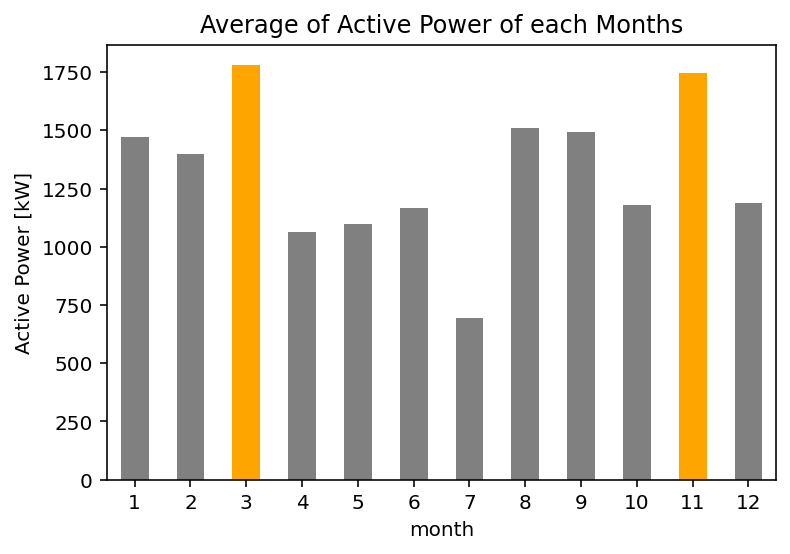

In [80]:
color = list(np.full(12, 'grey'))
color[2], color[10] = 'orange', 'orange'

df.groupby('month').mean().active_power.plot(kind='bar', title='Average of Active Power of each Months', color=color, rot=0)
plt.ylabel('Active Power [kW]')

Peak power on March and November, however power drop on July, October, and December.

<AxesSubplot:xlabel='date'>

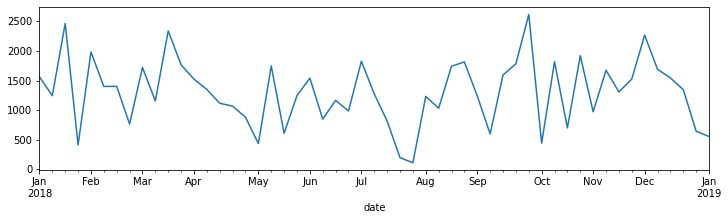

In [11]:
# Resample weekly average power and plot
df.resample('W').mean().active_power.plot(figsize=(12,3))

<AxesSubplot:xlabel='date'>

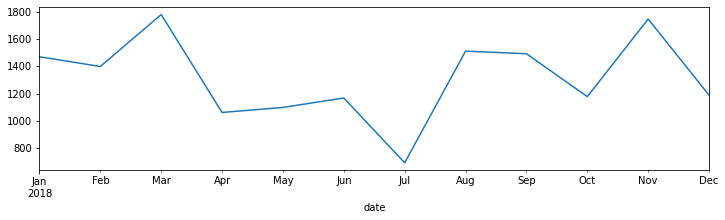

In [12]:
# Resample monthly average power and plot
df.resample('M').mean().active_power.plot(figsize=(12,3))

In [13]:
# Calculate power loss
df['loss'] = df['theor_power'] - df['active_power']

df

,active_power,wind_speed,theor_power,wind_dir,hour,month,loss
date,,,,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,0,1,36.281117
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,0,1,66.148316
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,0,1,84.523429
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,0,1,96.481664
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,0,1,111.052276
...,...,...,...,...,...,...,...
2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724,23,12,433.209835
2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599,23,12,-511.297256
2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500,23,12,-412.822178


<AxesSubplot:xlabel='date'>

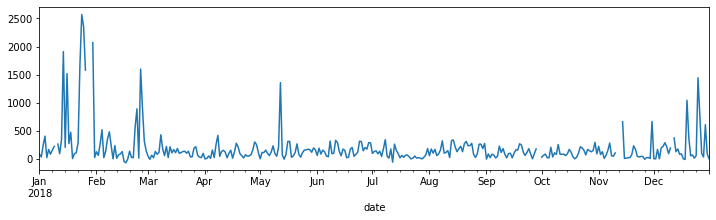

In [14]:
# Resample weekly average loss and plot
df.resample('D').mean().loss.plot(figsize=(12,3))

Severe power loss on many days in January, at the end of February, one day in May, and at the end of December. This can be due to maintainance. 

# 3. Wind power curve analysis

<AxesSubplot:xlabel='wind_speed'>

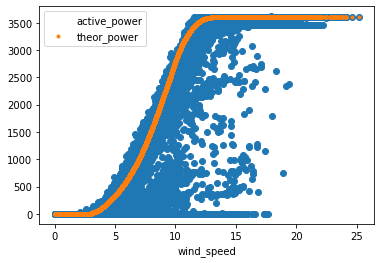

In [15]:
ax = df.plot(x='wind_speed', y='active_power', style='o')
df.plot(x='wind_speed', y='theor_power', style='.', ax=ax)

Too many values are plotted. We can bin the data by wind speed i.e. wind speed 0.25-0.75, 0.75-1.25, etc., then take average of the active power.

In [16]:
interval = np.arange(0.25,26,0.5)
df.groupby(pd.cut(df['wind_speed'], interval)).mean().head(10)

,active_power,wind_speed,theor_power,wind_dir,hour,month,loss
wind_speed,,,,,,,
"(0.25, 0.75]",0.000000,0.576992,0.000000,165.932577,11.127820,6.917293,0.000000
"(0.75, 1.25]",0.000505,1.017500,0.000000,177.411613,11.295671,7.026399,-0.000505
"(1.25, 1.75]",0.004856,1.513483,0.000000,174.603221,10.741866,6.890094,-0.004856
"(1.75, 2.25]",0.049437,2.009288,0.000000,170.506608,10.909741,6.815080,-0.049437
"(2.25, 2.75]",0.492883,2.508442,0.000000,161.085363,11.185185,6.690108,-0.492883
"(2.75, 3.25]",4.720572,3.004436,11.182960,153.013080,10.738693,6.503426,6.462388
"(3.25, 3.75]",25.595717,3.495974,53.255856,142.912788,11.095670,6.480866,27.660139
"(3.75, 4.25]",86.081460,4.006528,127.311184,136.855815,11.398386,6.618759,41.229725
"(4.25, 4.75]",167.611188,4.496874,221.949518,128.407628,11.831386,6.674962,54.338330


<AxesSubplot:xlabel='wind_speed'>

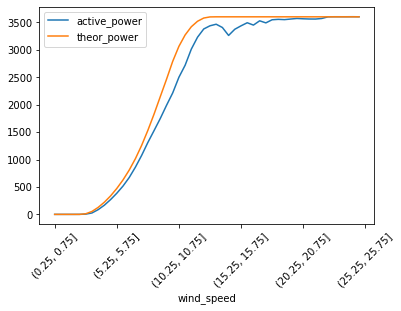

In [17]:
df.groupby(pd.cut(df['wind_speed'], interval)).mean().plot(y=['active_power', 'theor_power'], rot=45)

In [18]:
# A better look plot. This will display the mean value 0.5, 1, 1.5, etc., instead of the bins

def mean_power_curve(df):
    # Group by wind speed
    groups = df.groupby(pd.cut(df['wind_speed'], interval))

    mean_speed = []
    for key, item in groups:
        # Get keys from groupby method
        c = np.str(key)
        string = c[1:-1]
        string = string.split(', ')
        bounds = [float(i) for i in string]
        mean = np.mean(bounds)
        mean_speed.append(mean)

    # Take average of grouped df
    df_mean_speed = groups.mean()

    # Add mean speed to dataframe
    df_mean_speed['mean_speed'] = mean_speed

    # Plot
    df_mean_speed.plot(x='mean_speed', y=['theor_power', 'active_power'], style='.-')

Text(0.5, 1.0, 'Mean Power Curve')

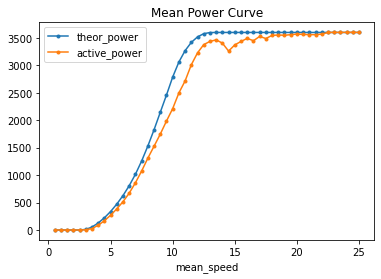

In [19]:
mean_power_curve(df)
plt.title('Mean Power Curve')
# plt.xlim(0,5)

The true power of wind turbine doesn't follow the theoretical power curve from manufacturer. There is a difference between theoretical and active power, called Loss, the new feature that we created before.

We also see that below 3.5 m/s wind speed, there is 0 active power (no production). We will later on use this 3.5 m/s wind speed as cutoff. 

# 4. Directivity analysis (+ power curve, again)

We would like to investigate Mean Power Curve plot for all directions. 

In [20]:
# create a function for a categorical column 
def direction(x):
    if x > 348.75 or x<11.25: return 'N'
    if x < 33.75: return 'NNE'
    if x < 56.25: return 'NE'
    if x < 78.75: return 'ENE'
    if x < 101.25: return 'E'
    if x < 123.75: return 'ESE'
    if x < 146.25: return 'SE'
    if x < 168.75: return 'SSE'
    if x < 191.25: return 'S'
    if x < 213.75: return 'SSW'
    if x < 236.25: return 'SW'
    if x < 258.75: return 'WSW'
    if x < 281.25: return 'W'
    if x < 303.75: return 'WNW'
    if x < 326.25: return 'NW'
    else: return 'NNW'

In [21]:
df['direction'] = df['wind_dir'].apply(direction)

df

,active_power,wind_speed,theor_power,wind_dir,hour,month,loss,direction
date,,,,,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,0,1,36.281117,W
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,0,1,66.148316,W
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,0,1,84.523429,W
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,0,1,96.481664,W
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,0,1,111.052276,W
...,...,...,...,...,...,...,...,...
2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724,23,12,433.209835,E
2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599,23,12,-511.297256,E
2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500,23,12,-412.822178,E


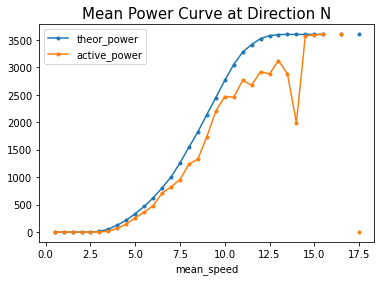

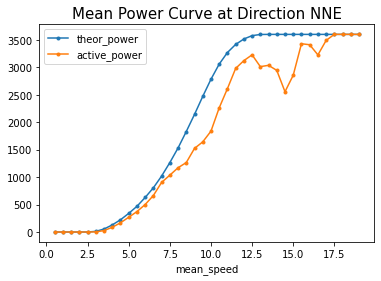

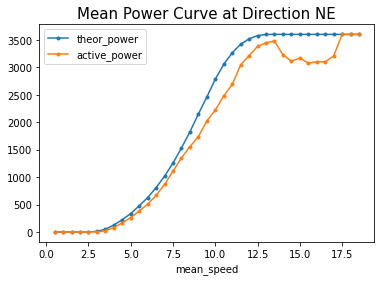

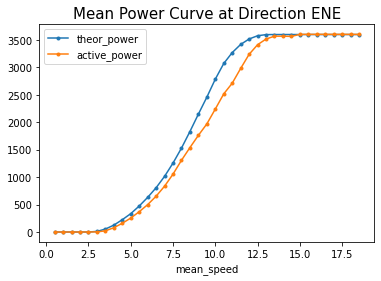

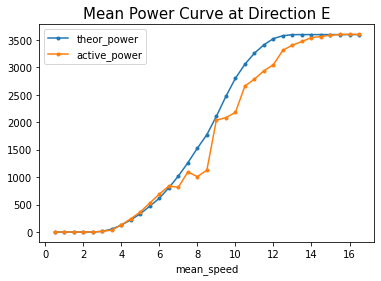

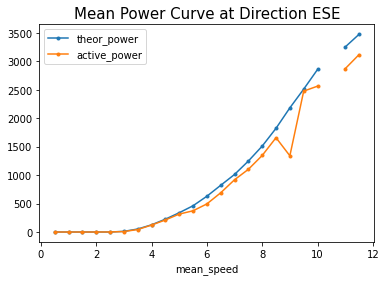

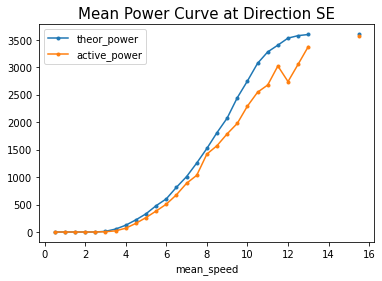

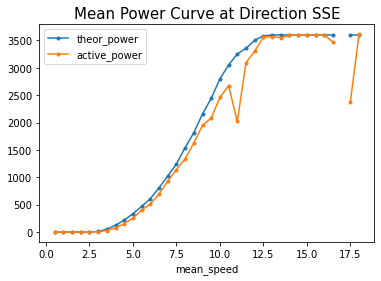

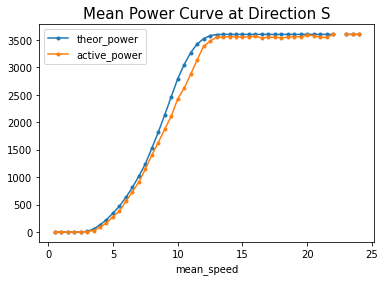

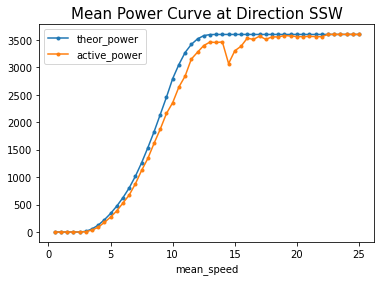

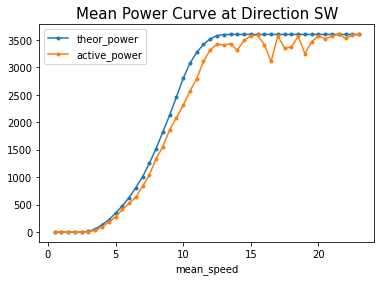

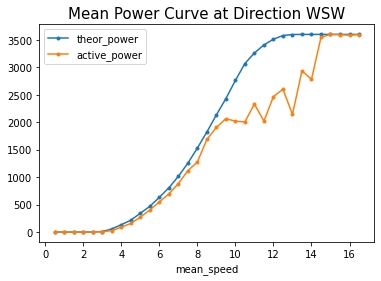

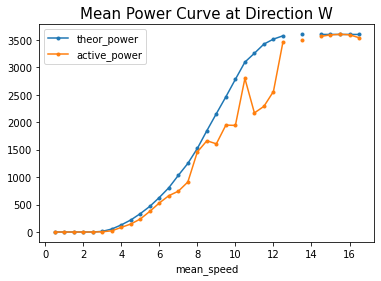

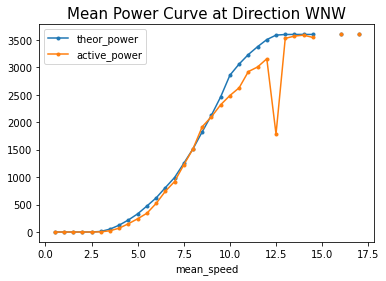

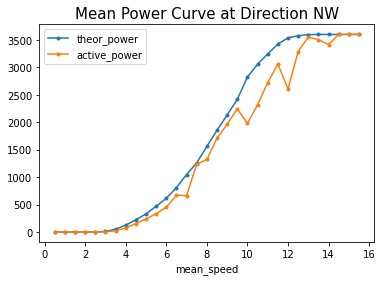

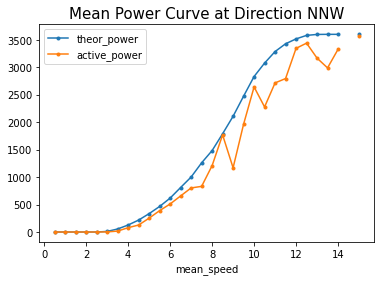

In [22]:
directions = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']

for d in directions:
    # Dataframe from one direction
    df_d = df[df.direction==d]
    # Plot mean power curve
    mean_power_curve(df_d)
    plt.title(f'Mean Power Curve at Direction {d}', size=15)
#     plt.xlim(0,5)

<AxesSubplot:title={'center':'Total Power Loss (kWh)'}, xlabel='direction'>

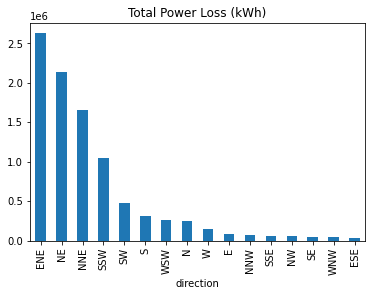

In [23]:
df.groupby('direction').loss.sum().sort_values(ascending=False).plot(kind='bar', title='Total Power Loss (kWh)')

<AxesSubplot:title={'center':'Wind Speed (m/s)'}, xlabel='direction'>

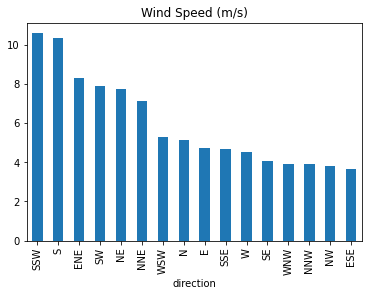

In [24]:
df.groupby('direction').wind_speed.mean().sort_values(ascending=False).plot(kind='bar', title='Wind Speed (m/s)')

In [25]:
# #function to create x,y component of wind direction 
# def x_y_component(wind_direction, wind_speed):
#     """
#     Convert degrees to x,y components
#     """
#     #convert to radians 
#     radians = (wind_direction * np.pi)/180
#     # give the x, y compenents 
#     x = wind_speed * np.cos(radians)
#     y = wind_speed * np.sin(radians)
    
#     return x,y

In [26]:
# # Calculate wind speed 
# wind_speed_x, wind_speed_y = x_y_component(df.wind_dir.values, df.wind_speed.values)

# df['wind_speed_x'] = wind_speed_x
# df['wind_speed_y'] = wind_speed_y

# df

## 5. Preparation for ML - Data cleansing, EDA

## Cleansing

We find negative active power (< 0 kWh) in the data. In Physics, negative power is normal, means losing power due to friction. Neither we know it is physically true nor it is erroneous records, we do not want to predict negative power. So we will remove it first. 

In [27]:
df2 = df.copy()

# Remove negative active power
df_outlier_removed = df2[df2.active_power>0]

df_outlier_removed

,active_power,wind_speed,theor_power,wind_dir,hour,month,loss,direction
date,,,,,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,0,1,36.281117,W
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,0,1,66.148316,W
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,0,1,84.523429,W
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,0,1,96.481664,W
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,0,1,111.052276,W
...,...,...,...,...,...,...,...,...
2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724,23,12,433.209835,E
2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599,23,12,-511.297256,E
2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500,23,12,-412.822178,E


## Outliers

We identify some events when there is power produced by the turbine although wind speed is below threshold 3 m/s.

In [28]:
# When wind speed is below 3.5, there is still power
df_outlier_removed[(df_outlier_removed.wind_speed<=3.5) & (df_outlier_removed.active_power!=0)]

,active_power,wind_speed,theor_power,wind_dir,hour,month,loss,direction
date,,,,,,,,
2018-01-01 12:30:00,41.947239,3.253968,29.286956,233.065903,12,1,-12.660283,SW
2018-03-01 15:30:00,7.347679,3.011371,16.374212,238.690598,15,3,9.026533,WSW
2018-03-01 15:50:00,12.344200,3.246252,28.731272,238.076508,15,3,16.387072,WSW
2018-05-01 07:30:00,13.934310,3.227394,27.413258,62.523109,7,5,13.478948,ENE
2018-05-01 08:10:00,22.780531,3.310203,33.624574,74.864113,8,5,10.844043,ENE
...,...,...,...,...,...,...,...,...
2018-12-18 01:40:00,6.939387,3.133558,21.700877,49.132389,1,12,14.761490,NE
2018-12-21 05:40:00,20.305180,2.648756,0.000000,175.433197,5,12,-20.305180,S
2018-12-21 05:50:00,4.730608,2.157747,0.000000,172.074402,5,12,-4.730608,S


And we identify some events when there is ZERO power produced although wind speed is above 3 m/s and theoretical power is expected to be not ZERO. We see these happen most frequently in January and December.

<AxesSubplot:xlabel='date'>

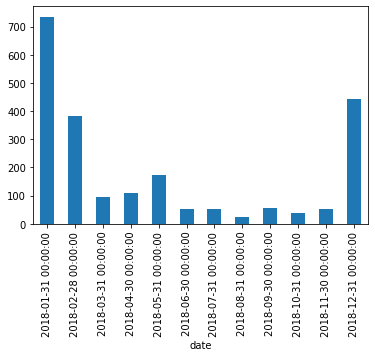

In [29]:
df_zero_power = df[(df.active_power==0) & (df.theor_power!=0) & (df.wind_speed>3.5)]

# Plot the frequency (counts) of ZERO power of every month
df_zero_power.resample('M').count().active_power.plot(kind='bar')

Interestingly, we can identify some events when active power exceeds theoretical power. This is very beneficial, but suspicious because active power is often lower than theoretical power.

<AxesSubplot:xlabel='date'>

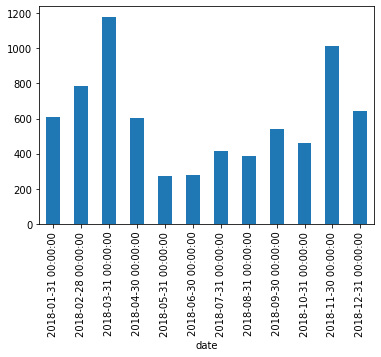

In [30]:
df[(df.active_power>df.theor_power)].resample('M').count().active_power.plot(kind='bar')

**Other notebooks attempted to remove records with very low wind speed (<3.5 m/s) and very high wind speed (> 25 m/s), or records with no production (0 kWh). However, in this notebook, we keep these records because we would like to include these events in our prediction i.e. when wind speed is 10 m/s but no production. Therefore, we do not clean remove power production.**

## EDA

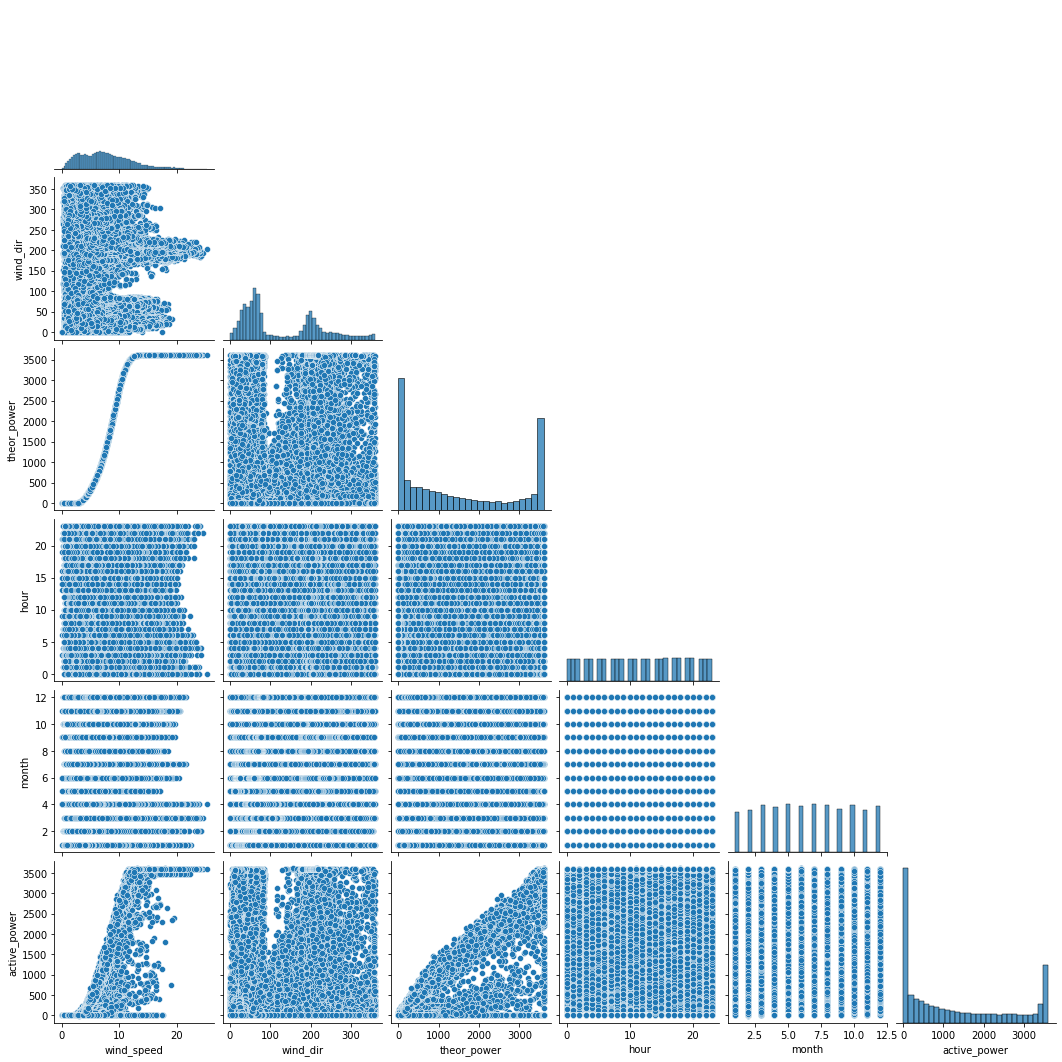

In [31]:
sns.pairplot(df, vars=['wind_speed', 'wind_dir', 'theor_power', 'hour', 'month', 'active_power'], corner=True)

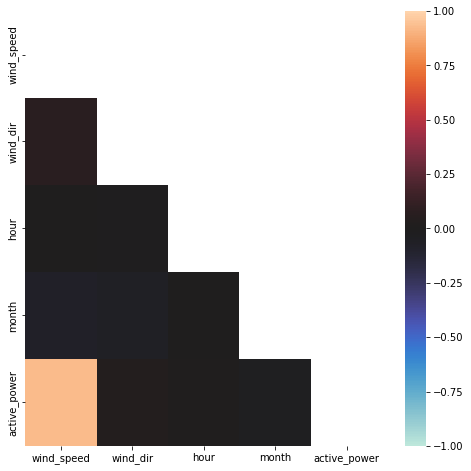

In [32]:
def corr_heatmap(df):    
    plt.figure(figsize=(8,8))

    mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
    sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, cmap='icefire')

corr_heatmap(df_outlier_removed[['wind_speed', 'wind_dir', 'hour', 'month', 'active_power']])

# 6. Power prediction

## Support Vector Machine

We made our first model, SVM, that will model the data **without** temporal information as features (hour and month). We would like to investigate "mathematically" the turbine power as a function of wind speed and wind direction.

In [33]:
# Features and target: use only wind direction and wind speed
X = df_outlier_removed[['wind_dir', 'wind_speed']]
y = df_outlier_removed['active_power']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Make pipeline
pipe = make_pipeline(StandardScaler(), SVR())

# 5-fold CV
r2_cv = cross_val_score(pipe, X_train, y_train, cv=5)
print(r2_cv)
print(np.mean(r2_cv))

[0.94164981 0.93732246 0.93972004 0.94354066 0.94329232]
0.9411050586370242


The 5-fold cross-validation R2 score of our SVM model is 94%.

In [34]:
# Fit SVM model
pipe.fit(X_train, y_train)

# Predict on test set
y_pred = pipe.predict(X_test)

# Train R2
print(f'Train R2: {pipe.score(X_train, y_train)}')

# Test R2, MSE, MAE
print(f'Test R2: {pipe.score(X_test, y_test)}')
print(f'Test MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'Test MSE: {mean_squared_error(y_test, y_pred)}')

Train R2: 0.9459030390874197
Test R2: 0.9422862160177913
Test MAE: 159.04878493315968
Test MSE: 92280.41669771016


Text(0, 0.5, 'Predicted Active Power')

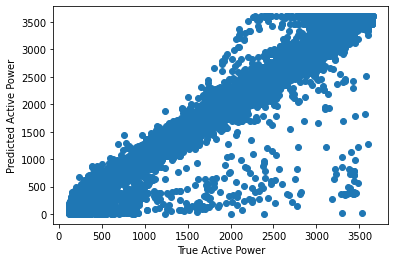

In [35]:
plt.scatter(y_pred, y_test)
plt.xlabel('True Active Power')
plt.ylabel('Predicted Active Power')

Predict on time-series.

In [36]:
# Entire data
y_pred_all = pipe.predict(X)

In [37]:
# Predicted power into dataframe
y_pred = pd.DataFrame(y_pred_all, columns=['active_power'])
y_pred.index = y.index

y_pred

,active_power
date,
2018-01-01 00:00:00,381.701960
2018-01-01 00:10:00,489.786169
2018-01-01 00:20:00,397.055540
2018-01-01 00:30:00,493.664820
2018-01-01 00:40:00,458.073894
...,...
2018-12-31 23:10:00,3043.763481
2018-12-31 23:20:00,1038.773078
2018-12-31 23:30:00,1593.731389


Text(0, 0.5, 'Active Power [kW]')

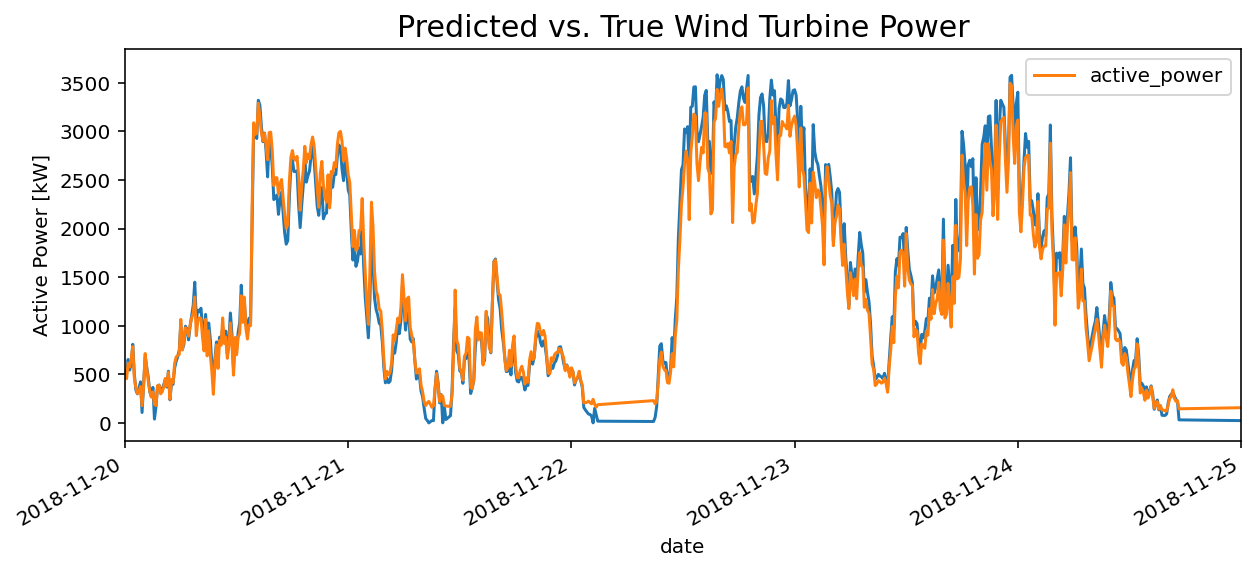

In [44]:
# True power (blue) vs. predicted power (orange)
t = df_outlier_removed.index
ax = y.plot(figsize=(10,4), xlim=(np.datetime64('2018-11-20'), np.datetime64('2018-11-25')))
y_pred.plot(figsize=(10,4), xlim=(np.datetime64('2018-11-20'), np.datetime64('2018-11-25')), ax=ax)
plt.title('Predicted vs. True Wind Turbine Power', size=15)
plt.ylabel('Active Power [kW]')

Let's visualize the non-linear function (our SVM hyperplane) of Active Power as a function of Wind Speed and Wind Direction, $P=f(w_s, w_d)$

In [45]:
ws = np.linspace(0, 26, 50)
wd = np.linspace(0, 360, 50)
ws, wd = np.meshgrid(ws, wd)

# Prediction space dataframe
X_space = pd.DataFrame({'wind_dir': wd.flatten(), 'wind_speed': ws.flatten()})

y_pred_space = pipe.predict(X_space)

In [63]:
pipe.steps[1][1].get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [64]:
pipe.steps[1][1]._gamma

0.5000000000000001

Text(0.5, 0.92, 'SVM (C=1, Gamma=0.5)')

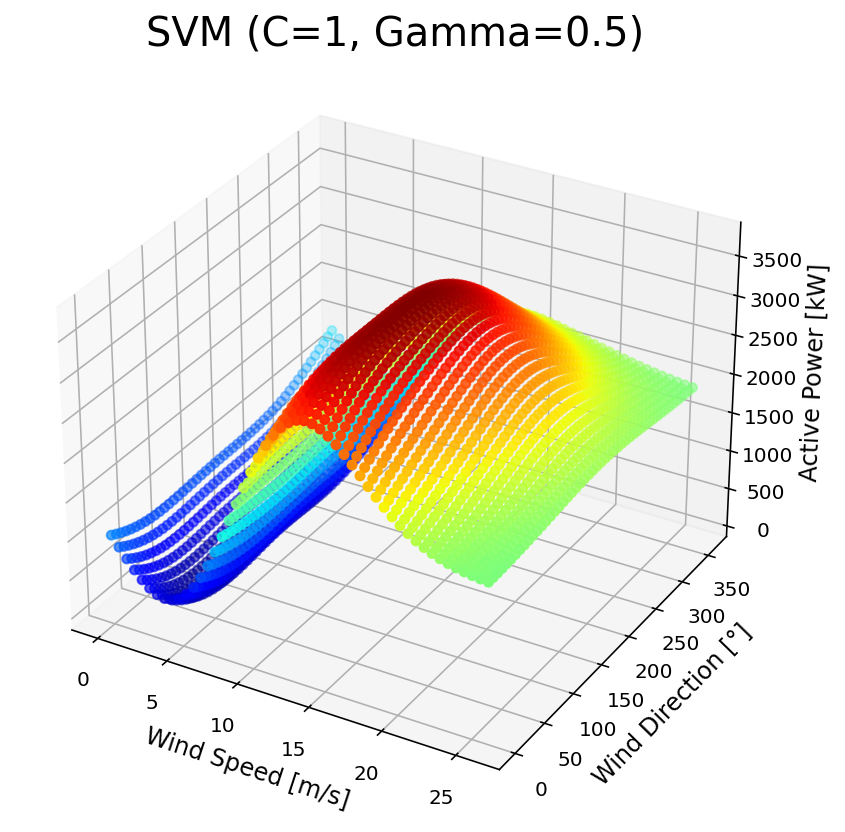

In [68]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(X_space.wind_speed.values, X_space.wind_dir.values, y_pred_space, 
             c=y_pred_space, cmap='jet')

# ax.scatter3D(X.wind_speed.values, X.wind_dir.values, y, 
#              c='b', alpha=0.2)

ax.set_xlabel('Wind Speed [m/s]', size=12)
ax.set_ylabel('Wind Direction [°]', size=12)
ax.set_zlabel('Active Power [kW]', size=12)
ax.set_title('SVM (C=1, Gamma=0.5)', size=20)

## Tree models

The second model, we will use tree models to include temporal information as features. We have seen that turbine power also varies with hour and month. We will compare 5 tree models and pick the best using 10-fold CV.

In [ ]:
# Features and target: now include hour and month as temporal features
X = df_outlier_removed[['wind_dir', 'wind_speed', 'hour', 'month']]
y = df_outlier_removed['active_power']

trees = [DTRegressor(), RFRegressor(), XGBRegressor(), Ada(), LGBMRegressor()]

for tree in trees:
    # Make pipeline
    pipe = make_pipeline(StandardScaler(), tree)
    
    # 10-fold CV
    r2_cv = cross_val_score(pipe, X_train, y_train, cv=10)
    print(f'{pipe.steps[1][1]}: {np.mean(r2_cv)}')

From the model comparison, Light Gradient Boosting Machine (LGBM) achieves the highest cross-validation R2 score of all tree models (scored 96%). It is also 2% higher than R2 score of our SVM.

# 7. Conclusion

From the data analytics part we got these:

1. The average power production is higher in March, August and November. Less production in January and December, beginning and end of the year.

2. The average power production is higher daily between 16:00 and 24:00.

3. The power production is higher when the wind blows from the directions between 000-090 and 180-225 degrees.

4. The wind speed threshold, or the smallest wind speed to produce power, is 3 m/s

5. The produced power does not follow the theoretical power curve due to losses in power.

6. There are some events when there is ZERO production when wind speed is above threshold 3 m/s. This can be due to maintanance or shut-down (cause is uncertain).

7. But, there are also some events when turbine produces power when wind speed is below threshold 3 m/s. Cause uncertain.

Based on these analysis, we made two predictive models. The first model is Support Vector Machine (SVM), which we did not include temporal features e.g. hour and month. With this model, we modeled turbine power as a function of wind speed and wind direction. Through 5-fold CV, the R2 score of our SVM is 94%. 

The second model we tried tree models to include temporal information. We compared the performance of 5 tree models and we found Light Gradient Boosting Machine (LGBM) had the highest R2 score of 96% through 5-fold CV. 